In [1]:
import pandas as pd
import numpy as np

import collections
import torch
import pickle
import time
import json
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from  gensim.models import KeyedVectors
from featurization import word2vec, featurizer
import model as m
from featurizer import ChungusSet 
from torch.utils.data import DataLoader
import geopy
from geopy.distance import geodesic
import constants
from torch.utils.data import Dataset

Let's use 8 GPUs!
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [2]:
# load word embeddings
def load_embedding():
    # load word2vec weights
    EpochSaver = word2vec.EpochSaver
    w2v = KeyedVectors.load_word2vec_format('./models/word2vec.model')

    weights = torch.FloatTensor(w2v.vectors)
    embedding = nn.Embedding.from_pretrained(weights)

    return embedding

embedding = load_embedding()

INFO - 17:22:38: loading projection weights from ./models/word2vec.model
INFO - 17:23:16: loaded (126352, 300) matrix from ./models/word2vec.model


In [4]:
# load model
path = "models/epoch_74.model"
model = m.Classifier(embedding)
model = nn.DataParallel(model, device_ids=[0,1,2,3,4,5,6,7])
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to("cuda:0")
batch_size = 256

In [61]:
def evaluate_model(model):
    test_set = pickle.load(open("data/test_set.p", "rb"))
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,num_workers=30, drop_last=True)
    print("Test set of %d entries" % len(test_set))
    
    y_pred = []
    l = []
    
    err=0
    tot = 0
    with torch.no_grad():
        i = 0
        for (words, subs, times, labels) in test_loader:
            # remove subs, see how model does
            # subs = torch.zeros(batch_size, 5000)   
            
            output = model(words, subs, times, labels)
            
            print(output.size())
            # let the maximum index be our predicted class
            _, yh = torch.max(output, 1)
            
            l += list(labels)
            y_pred += output.tolist()
            
            tot += labels.size(0)
            
            i+=1
            if(i % 10 == 0):
                print("Iteration: %d, processed %d labels" % (i, tot))
                print(labels.size())
            
            ## add to err number of missclassification, i.e. number of indices that
            ## yh and y are not equal
            ## note that y and yh are vectors of size = batch_size = (256 in our case)
            err += sum(list(map(lambda i: 1 if labels[i] != yh[i] else 0, range(len(labels)))))

    print('Accuracy of FC prediction on test users: %5.2f%%' % (100-100 * err / tot))
    
    return (y_pred, l)

In [62]:
y_pred, l = evaluate_model(model)

Test set of 10755 entries
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
Iteration: 10, processed 2560 labels
torch.Size([256])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
Iteration: 20, processed 5120 labels
torch.Size([256])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
Iteration: 30, processed 7680 labels
torch.Size([256])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 51])
torch.Size([256, 

In [65]:
print(len(y_pred))
print(len(l))

def maxN(elements, n):
    return sorted(elements, reverse=True)[:n]

tops = np.zeros(51)

for i in range(len(y_pred)):
    p = y_pred[i]
    label = l[i].item()
    
    # sort indices to get most common state
    indices = list(range(len(p)))
    indices.sort(key = lambda i: p[i], reverse=True)
    
    # get position of this index
    pos = indices.index(label)
    # increment everything at pos and after
    for j in range(pos, 51):
        tops[j] +=1
    

10752
10752


[ 6424.  7453.  7914.  8198.  8389.  8538.  8684.  8798.  8924.  9028.
  9118.  9201.  9279.  9351.  9413.  9497.  9562.  9615.  9665.  9719.
  9758.  9817.  9860.  9902.  9944.  9994. 10035. 10085. 10121. 10172.
 10215. 10246. 10277. 10308. 10337. 10367. 10403. 10439. 10468. 10497.
 10528. 10549. 10585. 10603. 10623. 10646. 10665. 10683. 10705. 10736.
 10752.]
[0, 0.5974702380952381, 0.6931733630952381, 0.7360491071428571, 0.7624627976190477, 0.7802269345238095, 0.7940848214285714, 0.8076636904761905, 0.8182663690476191, 0.8299851190476191, 0.8396577380952381, 0.8480282738095238, 0.8557477678571429, 0.8630022321428571, 0.8696986607142857, 0.8754650297619048, 0.8832775297619048, 0.8893229166666666, 0.8942522321428571, 0.8989025297619048, 0.9039248511904762, 0.9075520833333334, 0.9130394345238095, 0.9170386904761905, 0.9209449404761905, 0.9248511904761905, 0.9295014880952381, 0.9333147321428571, 0.9379650297619048, 0.9413132440476191, 0.9460565476190477, 0.9500558035714286, 0.9529389880

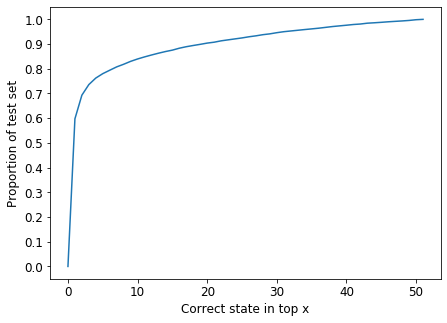

In [96]:
print(tops)

frac_tops = [0]
frac_tops.extend(tops/len(l))
print(frac_tops)

plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams.update({'font.size': 12})

print(len(frac_tops), len(range(0,52)))
plt.plot(range(0,52), frac_tops)
plt.ylabel("Proportion of test set")
plt.xlabel("Correct state in top x")
plt.yticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [114]:
# mean error dist

center_dict = pickle.load(open("center_dict.p", "rb"))
print(center_dict)


cali_preds = []
ind_preds = []

errs = []

total_dist = 0
for i in range(len(y_pred)):
    pred_state = np.argmax(y_pred[i])
    label = l[i].item()
        
    pred_coord = center_dict[constants.states[pred_state]]
    act_coord = center_dict[constants.states[label]]
    
    if(constants.states[label] == "California"):
        cali_preds.append(constants.states[pred_state])
    elif(constants.states[label] == "Indiana"):
        ind_preds.append(constants.states[pred_state])
    
    
    err = geodesic(pred_coord, act_coord).miles
    errs.append(err)
    #print("Error of %f" % err)
    total_dist += err
    
print("Average distance error of %f" % (total_dist/len(y_pred)))

{'Alaska': (64.4459613, -149.680909), 'Alabama': (33.2588817, -86.8295337), 'Arkansas': (35.2048883, -92.4479108), 'Arizona': (34.395342, -111.7632755), 'California': (36.7014631, -118.7559974), 'Colorado': (38.7251776, -105.6077167), 'Connecticut': (41.6500201, -72.7342163), 'District of Columbia': (38.89379365, -76.98799757261312), 'Delaware': (38.6920451, -75.4013315), 'Florida': (27.7567667, -81.4639835), 'Georgia': (32.3293809, -83.1137366), 'Hawaii': (19.58726775, -155.42688965312746), 'Iowa': (41.9216734, -93.3122705), 'Idaho': (43.6447642, -114.0154071), 'Illinois': (40.0796606, -89.4337288), 'Indiana': (40.3270127, -86.1746933), 'Kansas': (38.27312, -98.5821872), 'Kentucky': (37.5726028, -85.1551411), 'Louisiana': (30.8703881, -92.007126), 'Massachusetts': (42.3788774, -72.032366), 'Maryland': (39.5162234, -76.9382069), 'Maine': (45.709097, -68.8590201), 'Michigan': (43.6211955, -84.6824346), 'Minnesota': (45.9896587, -94.6113288), 'Missouri': (38.7604815, -92.5617875), 'Missi

0.0


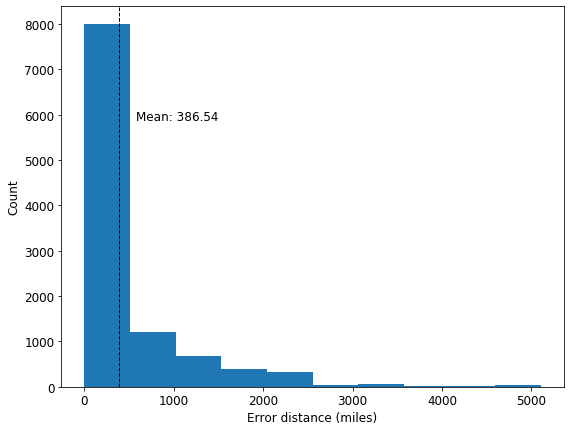

In [136]:
plt.rcParams['figure.figsize'] = [9, 7]
plt.hist(errs, bins = 10)
plt.ylabel("Count")
plt.xlabel("Error distance (miles)")
plt.axvline(np.mean(errs), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(errs)*1.5, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(errs)))

print(np.median(errs))

In [38]:
# populate mapping of state -> pred/actual
results = dict()

for i in range(51):
    # for each state, add arrays
    results[i] = {"predicted": set(), "actual": set()}

# for each state, add to its actual and predicted arrays
assert(len(l) == len(y_pred))
for i in range(len(l)):
    pred_state = np.argmax(y_pred[i])
    actual_state = l[i].item()
    results[pred_state]["predicted"].add(i)
    results[actual_state]["actual"].add(i)
    continue


a= 0 
b=0
for s in results:
    row = results[s]
    a += len(row['predicted'])
    b += len(row['actual'])
    
assert(a == b)
assert(a == len(l))

In [48]:
def calc_precision(pred, actual):
    # defined as fraction of events where we correctly predictions the state out of all predictions
    deno = len(pred)
    
    # fraction of 
    num = len(pred & actual)

    print(num, deno)
    return (num, deno)
    # for each entry in pred, check if in actual
    
def calc_recall(pred, actual):
    # defined as fraction of events where we correctly predictions the state out of all predictions
    deno = len(actual)
    
    # fraction of 
    num = len(pred & actual)

    print(num, deno)
    # for each entry in pred, check if in actual
    return (num, deno)
    
    

In [51]:
# compute precision and recall
a = 0
b = 0

superlatives = [-1,-1,-1,-1]
worst_prec = 1
best_prec = 0
worst_rec = 1
best_rec = 0

for i in range(51):
    pred = results[i]['predicted']
    actual = results[i]['actual']
    print(constants.states[i], len(pred), len(actual))
    
    precision = calc_precision(pred, actual)
    recall = calc_recall(pred, actual)
    
    p = precision[0]/precision[1]
    r = recall[0]/recall[1]
    print(p, r)
    if(p < worst_prec):
        worst_prec = p
        print("Is worst precision")
        superlatives[0] = i
    if(p > best_prec):
        best_prec = p
        print("Is best precision")
        superlatives[1] = i
    if(r < worst_rec):
        worst_rec = r
        print("Is worst rec")
        superlatives[2] = i
    if(r > best_rec):
        best_rec = r
        print("Is best rec")
        superlatives[3] = i

print(np.array(constants.states)[superlatives])

Alaska 109 160
66 109
66 160
0.6055045871559633 0.4125
Is worst precision
Is best precision
Is worst rec
Is best rec
Alabama 96 157
74 96
74 157
0.7708333333333334 0.4713375796178344
Is best precision
Is best rec
Arkansas 114 145
83 114
83 145
0.7280701754385965 0.5724137931034483
Is best rec
Arizona 257 289
170 257
170 289
0.6614785992217899 0.5882352941176471
Is best rec
California 729 498
377 729
377 498
0.5171467764060357 0.7570281124497992
Is worst precision
Is best rec
Colorado 354 328
213 354
213 328
0.6016949152542372 0.649390243902439
Connecticut 248 245
141 248
141 245
0.5685483870967742 0.5755102040816327
District of Columbia 288 242
131 288
131 242
0.4548611111111111 0.5413223140495868
Is worst precision
Delaware 86 128
53 86
53 128
0.6162790697674418 0.4140625
Florida 426 359
226 426
226 359
0.5305164319248826 0.6295264623955432
Georgia 296 279
184 296
184 279
0.6216216216216216 0.6594982078853047
Hawaii 122 129
80 122
80 129
0.6557377049180327 0.6201550387596899
Iowa 141 

In [ ]:
# precision
# worst: ND 0.36363636363636365
# best: Alabama 0.7708

# recall
# worst: Wyoming 0.12345679012345678
# best: California 0.757

In [76]:
# print confusion matrix
from sklearn.metrics import confusion_matrix

# unpack values
y_true = list(map(lambda t: t.item(), l))
y_p = list(map(lambda p: np.argmax(p), y_pred))

# generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_p, labels=range(51), normalize='true')

In [104]:
from matplotlib.pyplot import figure
from matplotlib.pyplot import cm

figure(num=None, figsize=(50, 50), dpi=200, facecolor='w', edgecolor='k')

def tick_to_state(tick_val, tick_pos):
    if int(tick_val) in xs:
        return labels[int(tick_val)]
    else:
        return ''
ax = plt.gca()

ticks = np.linspace(0, 50, num=51)
plt.imshow(conf_matrix, interpolation='none', cmap= cm.Blues)
plt.colorbar()
plt.xticks(ticks, fontsize=8)
plt.yticks(ticks, fontsize=8)

ax.set_xticklabels(constants.states)
ax.set_yticklabels(constants.states)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# add annotation for actual matching
for i in range(len(constants.states)):
    for j in range(len(constants.states)):
        if i == j:
            text = ax.text(j, i, np.round(conf_matrix[i, j], decimals=2),
                           ha="center", va="center", color="w", fontsize=10)

ax.set_title("Actual state vs. Predicted state", fontsize=50)
ax.set_xlabel("Predicted state", fontsize=30)
ax.set_ylabel("Actual state", fontsize=30)
plt.grid(True)
plt.show()